In [1]:
# Harshadeep Kambhampati (hk24873), Ian Wang, Arkady Marchenko, Andy Jiang

# ML Course Project

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [3]:
# Import data
df = pd.read_csv("cattle_data_train.csv")
df.info()
df.describe()


# print((df['Rumination_Time_hrs'] < 0).sum())


# OBSERVATIONS from describe():
# 34 actual features to predict with (excluding Cattle_ID and Milk_Yield_L as our class label)
# No NaNs except for housing_score and feed_quantity in both kg and lbs: not too many, 10000 ish out of 200000
# The min of Milk Yield for some reason is negative, which doesn't make sense?... what even is a negative yield
# What is a negative Rumination Time (the bottom 50% is all negative)? 
# Parity is the number of times a cow has given birth

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Cattle_ID                210000 non-null  object 
 1   Breed                    210000 non-null  object 
 2   Climate_Zone             210000 non-null  object 
 3   Management_System        210000 non-null  object 
 4   Age_Months               210000 non-null  int64  
 5   Weight_kg                210000 non-null  float64
 6   Parity                   210000 non-null  int64  
 7   Lactation_Stage          210000 non-null  object 
 8   Days_in_Milk             210000 non-null  int64  
 9   Feed_Type                210000 non-null  object 
 10  Feed_Quantity_kg         199519 non-null  float64
 11  Feeding_Frequency        210000 non-null  int64  
 12  Water_Intake_L           210000 non-null  float64
 13  Walking_Distance_km      210000 non-null  float64
 14  Graz

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,...,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Feed_Quantity_lb,Mastitis,Milk_Yield_L
count,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,...,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000
mean,83.483905,499.930430,3.500395,182.112967,12.014793,2.999119,80.036850,4.034754,6.056710,0.256557,...,0.600381,0.598814,0.599824,0.600824,8.747584,3.394726,12.302438,26.492720,0.099976,15.589156
std,34.648982,144.659172,1.707383,105.051486,3.969247,1.413147,14.987677,1.928529,2.867575,6.115351,...,0.489821,0.490140,0.489935,0.489730,5.901473,0.632831,4.298998,8.741282,0.299969,5.352079
min,24.000000,250.000000,1.000000,1.000000,2.370284,1.000000,14.207737,0.500000,1.000000,-8.808053,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,6.615000,0.000000,-5.700324
25%,54.000000,374.200000,2.000000,91.000000,9.283265,2.000000,69.919162,2.650000,4.000000,-4.383302,...,0.000000,0.000000,0.000000,0.000000,4.270000,3.000000,12.000000,20.506500,0.000000,11.822207
50%,83.000000,500.200000,3.000000,182.000000,12.002254,3.000000,80.016973,4.000000,6.000000,-0.818631,...,1.000000,1.000000,1.000000,1.000000,7.710000,3.500000,12.000000,26.460000,0.000000,15.145871
75%,114.000000,625.700000,5.000000,273.000000,14.708920,4.000000,90.119812,5.350000,8.000000,4.051704,...,1.000000,1.000000,1.000000,1.000000,12.410000,4.000000,12.000000,32.413500,0.000000,18.884708
max,143.000000,750.000000,6.000000,364.000000,25.454207,5.000000,149.960210,12.000000,14.000000,31.263406,...,1.000000,1.000000,1.000000,1.000000,38.670000,5.000000,24.000000,55.125000,1.000000,44.555285


# Data Cleaning

In [4]:
# DATA CLEANING (outside of pipeline)

# Dropping Cattle_ID as it is just an identifier, not useful for prediction
df = df.drop(columns=['Cattle_ID'])

# Converting our Date into a day of the year and year features, usable numeric data
df['Date'] = pd.to_datetime(df['Date'])
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Year'] = df['Date'].dt.year
df = df.drop(columns=['Date'])


# Handling NaN values for Feed_Quantity: We will keep only KG and convert LBS to KG for NaNs, then drop LBS
FEED_QTY_LBS_TO_KG = 0.453592
df['Feed_Quantity_kg'] = df['Feed_Quantity_kg'].fillna(df['Feed_Quantity_lb'] * FEED_QTY_LBS_TO_KG)
df = df.drop(columns=['Feed_Quantity_lb'])
print("Number of missing values after lb to kg conversion (we may need to handle with imputation later):", df.isna().sum().sum())


# NOTE: Something weird we noticed here is that we have some different string representations of the same breed due to trailing spaces and spelling ('Holstein' and 'Holstein ')
# We should probably clean that up right now
df['Breed'] = df['Breed'].str.strip()
df['Breed'] = df['Breed'].replace('Holstien', 'Holstein')
for b in df['Breed'].unique():
    print(repr(b))


# We should drop our "negative" milk yields as those entries don't really make sense
print("Number of negative milk yield entries being dropped:", (df['Milk_Yield_L'] < 0).sum())
df = df[df['Milk_Yield_L'] >= 0]

# Something we noticed during exploration, we have a lot of entries with Previous_Week_Avg_Yield = 0 (about 6600)
# BUT they seem to have perfectly normal Milk_Yield_L and Days_in_Milk values, which doesn't make sense at all. How can a cow have 0
# average yield last week but have a positive yield this week and have been in milk for many days?
# We assume these 0s to be implicit NaNs and these cows must have missing data for their last week yield, we will impute them later
# There may also be some association between all of these 0 previous week yields, so we will create a new feature as a flag for this
print("Number of entries with Previous_Week_Avg_Yield = 0:", (df['Previous_Week_Avg_Yield'] == 0).sum())

zero_prev = df[df['Previous_Week_Avg_Yield'] == 0]
print(zero_prev['Milk_Yield_L'].describe())
print(zero_prev['Days_in_Milk'].describe())

df['Previous_Week_Avg_Yield'] = df['Previous_Week_Avg_Yield'].replace(0, np.nan)


Number of missing values after lb to kg conversion (we may need to handle with imputation later): 16760
'Holstein'
'Jersey'
'Guernsey'
'Brown Swiss'
Number of negative milk yield entries being dropped: 74
Number of entries with Previous_Week_Avg_Yield = 0: 6662
count    6662.000000
mean       14.821080
std         5.316991
min         0.392622
25%        11.046382
50%        14.440192
75%        18.111401
max        41.531320
Name: Milk_Yield_L, dtype: float64
count    6662.000000
mean      202.692735
std       113.767234
min         1.000000
25%       102.000000
50%       222.000000
75%       308.000000
max       364.000000
Name: Days_in_Milk, dtype: float64


# Data Exploration

## Numerical Analysis

In [5]:
# DATA EXPLORATION
# NOTE: We should really finish encoding all of our categorical features properly before analyzing correlation/variance
# TODO: We should probably use some data visualizations/distributions here as well for exploration
# TODO: Identify outliers

# target_corr = df.corr(numeric_only=True)['Milk_Yield_L'].sort_values(ascending=False)
# print(target_corr)


# Let's take a look at the correlation between each of the features and the label
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

df_encoded.corr()['Milk_Yield_L'].sort_values(ascending=False)

# Observations:
# - Interestingly, Weight_kg, Feed_Quantity_kg, Age_Months, Parity all have the highest correlation over 0.2
# - We have a lot of very low correlation features that may be best to drop
# - Since Feed_Quantity_kg actually has a high correlation, we should have good imputation for it to avoid losing that info for missing entries

Milk_Yield_L               1.000000
Weight_kg                  0.300240
Feed_Quantity_kg           0.222856
Water_Intake_L             0.125022
Rumination_Time_hrs        0.089412
Previous_Week_Avg_Yield    0.086917
IBR_Vaccine                0.072186
Anthrax_Vaccine            0.069584
Rabies_Vaccine             0.068090
Milking_Interval_hrs       0.014635
Grazing_Duration_hrs       0.004278
Housing_Score              0.004054
Humidity_percent           0.002337
Brucellosis_Vaccine        0.002065
Year                       0.001998
BVD_Vaccine                0.000692
Breed                      0.000636
Feeding_Frequency          0.000465
Farm_ID                    0.000105
HS_Vaccine                -0.000038
Climate_Zone              -0.000451
Feed_Type                 -0.000488
BQ_Vaccine                -0.000576
Walking_Distance_km       -0.001608
Resting_Hours             -0.001703
Body_Condition_Score      -0.001951
Management_System         -0.002054
FMD_Vaccine               -0

In [6]:
# Let's also check for variance across all features and see if we have any low variance features to consider filtering
feature_variances = df_encoded.var().sort_values()
print(feature_variances)

# Seems like all of the features demonstrate some variance, looks significant enough not to drop any based on variance alone

Housing_Score                  0.041013
Mastitis                       0.089968
Rabies_Vaccine                 0.239815
BQ_Vaccine                     0.239857
Anthrax_Vaccine                0.239919
Brucellosis_Vaccine            0.239986
BVD_Vaccine                    0.240043
HS_Vaccine                     0.240069
FMD_Vaccine                    0.240142
IBR_Vaccine                    0.240230
Body_Condition_Score           0.400456
Year                           0.665733
Lactation_Stage                0.690784
Breed                          0.885638
Feeding_Frequency              1.997108
Management_System              1.999275
Parity                         2.914924
Climate_Zone                   2.917710
Walking_Distance_km            3.719208
Feed_Type                      5.246443
Resting_Hours                  8.211616
Grazing_Duration_hrs           8.223133
Feed_Quantity_kg              15.753011
Milking_Interval_hrs          18.482684
Milk_Yield_L                  28.551332


In [7]:
# Checking for any outliers in the data and how severe of a problem this may be for the model later on down the line

for col in df.select_dtypes(include=[np.number]).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df):.2%})")

    # Most features look good, but Milking_Interval_hrs is absurd with 30% outliers and Mastitis with 10% outliers
    # Mastitis is a binary feature, so those outliers are probably just the less common class
    # Milking_Interval_hrs looks like it just has a multi-modal distribution so these outliers look fine as well

Age_Months: 0 outliers (0.00%)
Weight_kg: 0 outliers (0.00%)
Parity: 0 outliers (0.00%)
Days_in_Milk: 0 outliers (0.00%)
Feed_Quantity_kg: 674 outliers (0.32%)
Feeding_Frequency: 0 outliers (0.00%)
Water_Intake_L: 1483 outliers (0.71%)
Walking_Distance_km: 747 outliers (0.36%)
Grazing_Duration_hrs: 0 outliers (0.00%)
Rumination_Time_hrs: 2406 outliers (1.15%)
Resting_Hours: 0 outliers (0.00%)
Ambient_Temperature_C: 196 outliers (0.09%)
Humidity_percent: 0 outliers (0.00%)
Housing_Score: 0 outliers (0.00%)
FMD_Vaccine: 0 outliers (0.00%)
Brucellosis_Vaccine: 0 outliers (0.00%)
HS_Vaccine: 0 outliers (0.00%)
BQ_Vaccine: 0 outliers (0.00%)
Anthrax_Vaccine: 0 outliers (0.00%)
IBR_Vaccine: 0 outliers (0.00%)
BVD_Vaccine: 0 outliers (0.00%)
Rabies_Vaccine: 0 outliers (0.00%)
Previous_Week_Avg_Yield: 2426 outliers (1.16%)
Body_Condition_Score: 0 outliers (0.00%)
Milking_Interval_hrs: 62813 outliers (29.92%)
Mastitis: 20984 outliers (10.00%)
Milk_Yield_L: 2604 outliers (1.24%)
Day_of_Year: 0 o

## Data Visualization

Numeric columns: 29


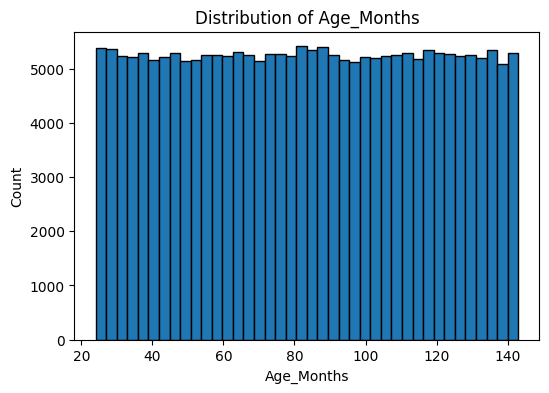

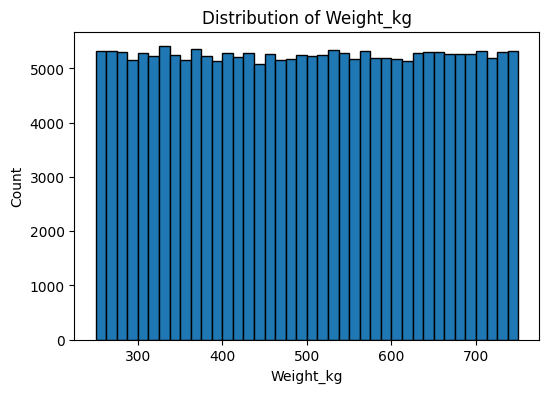

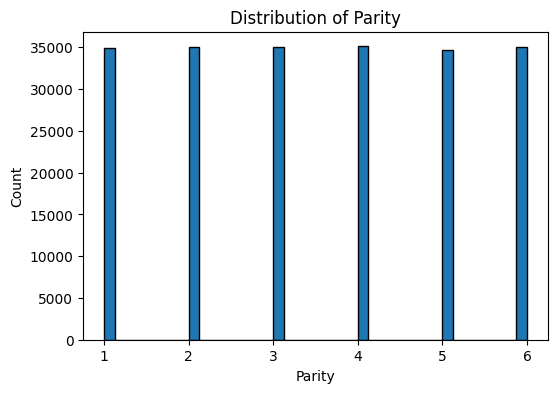

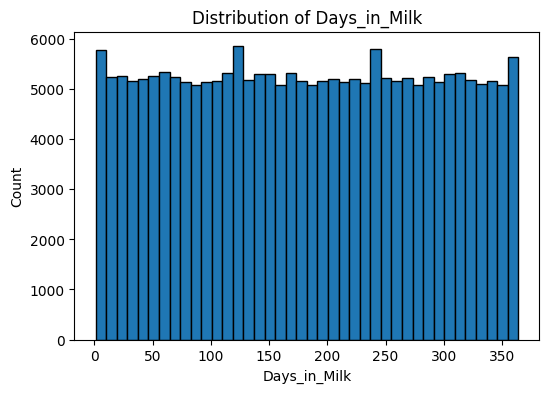

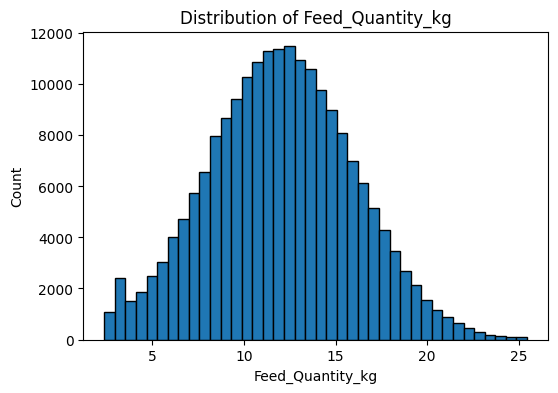

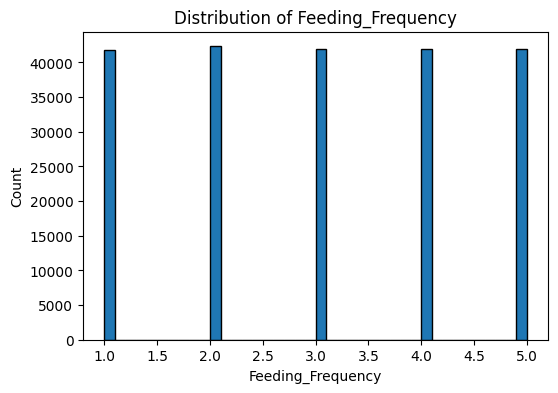

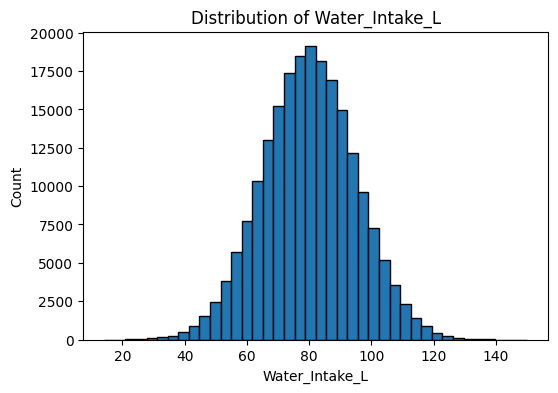

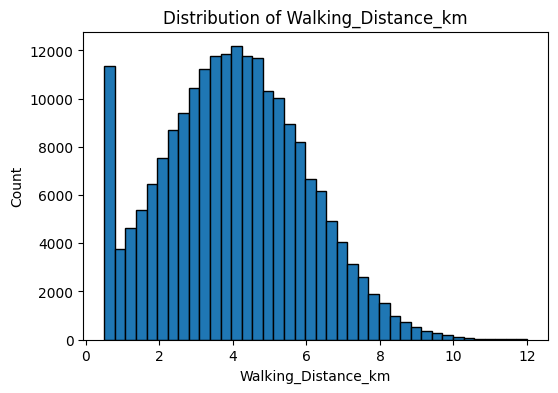

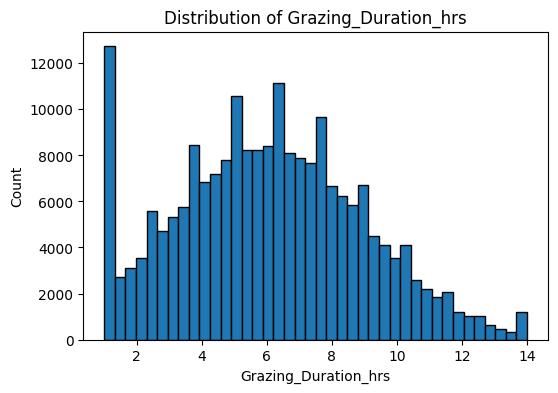

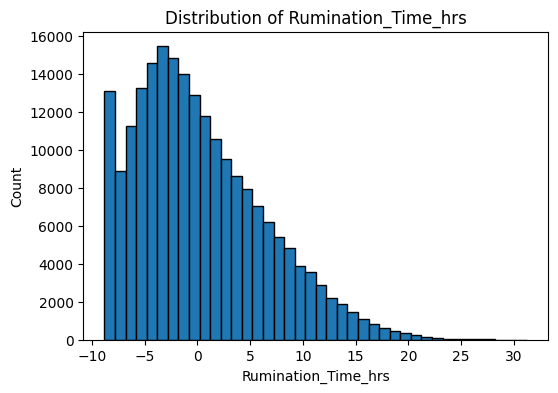

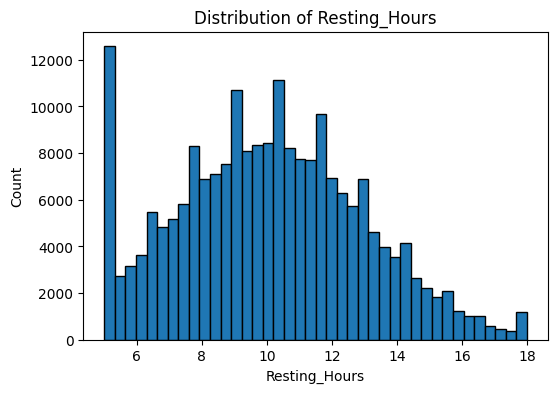

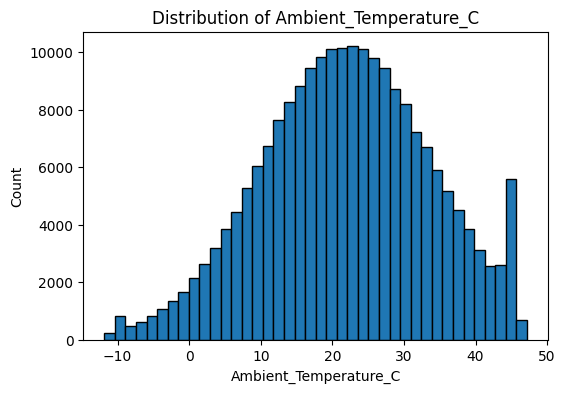

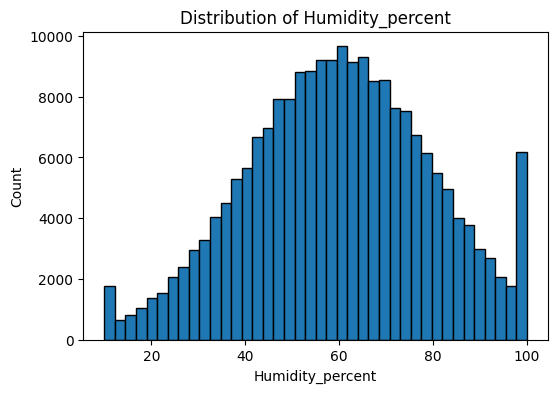

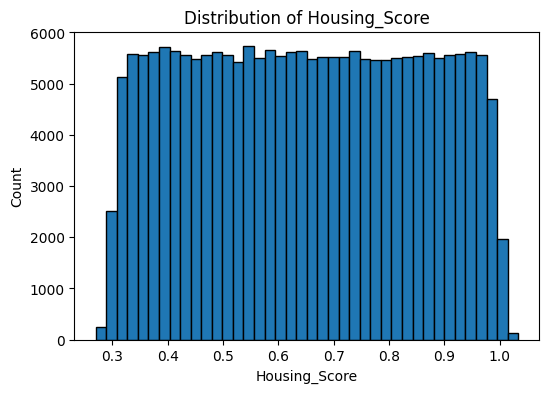

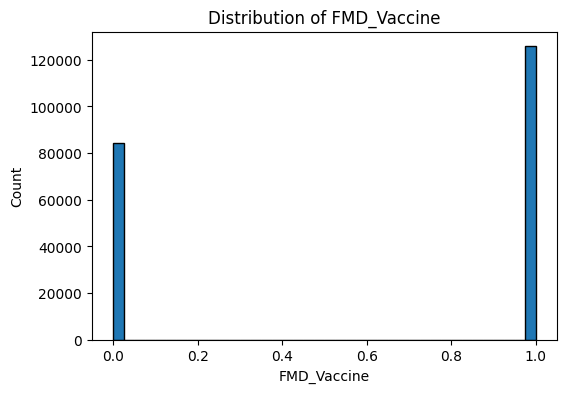

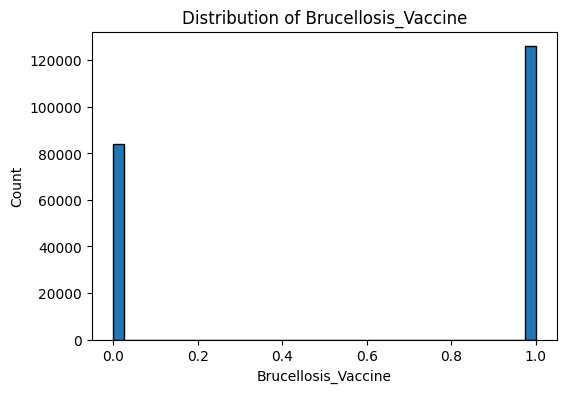

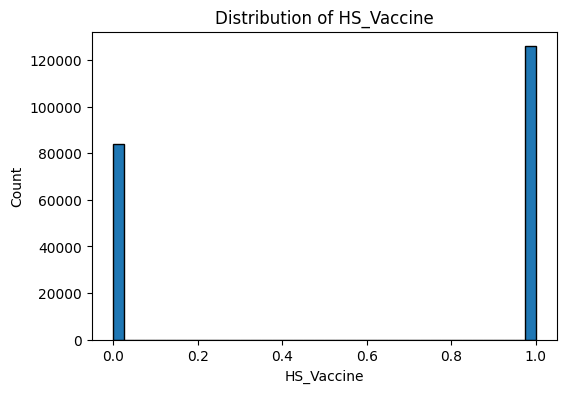

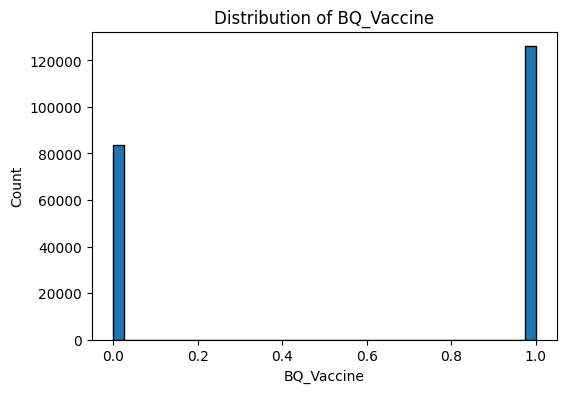

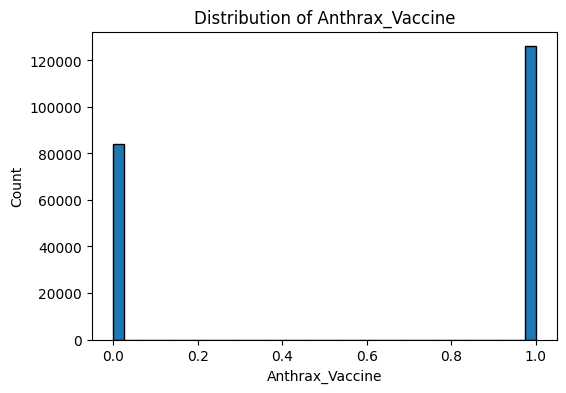

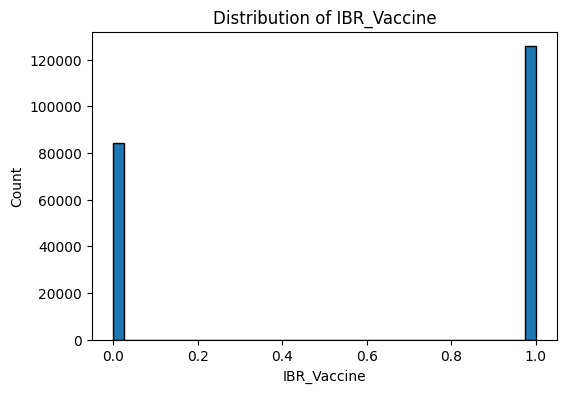

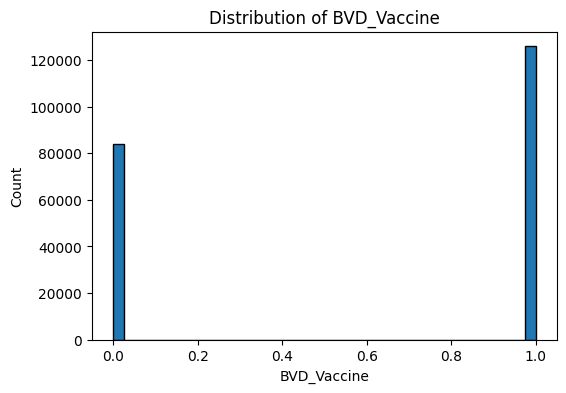

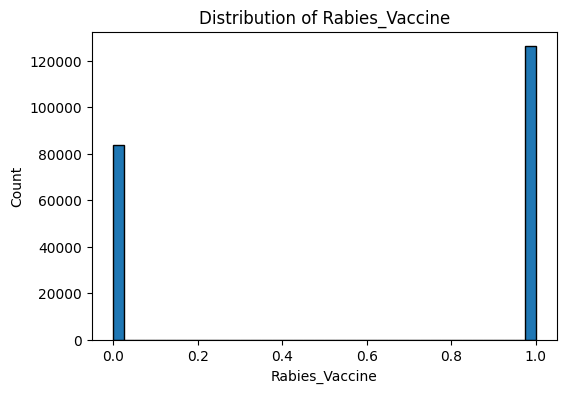

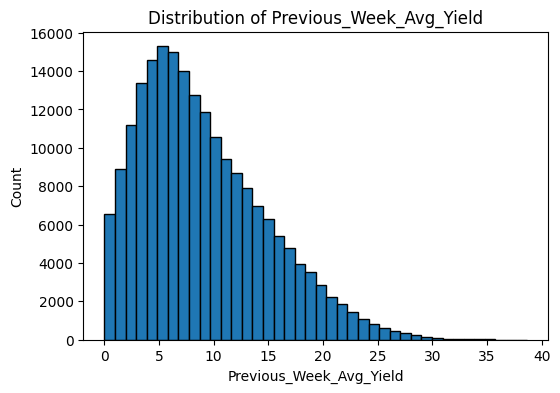

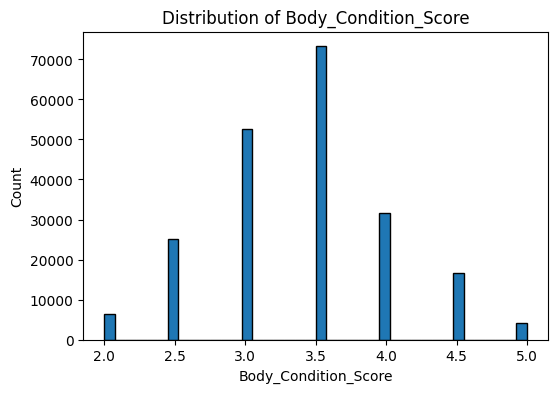

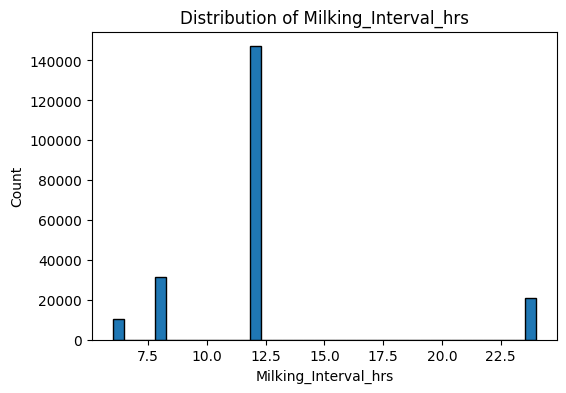

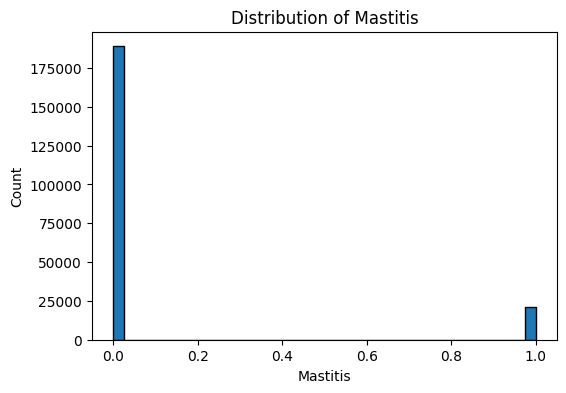

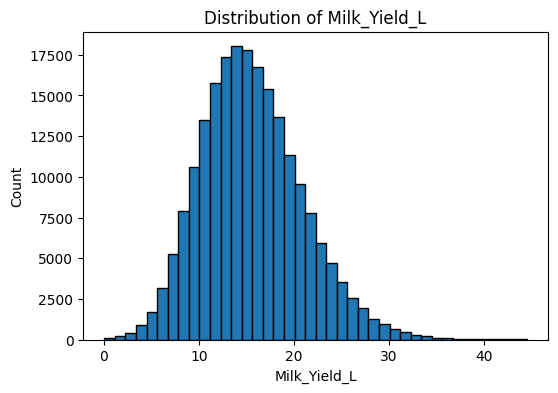

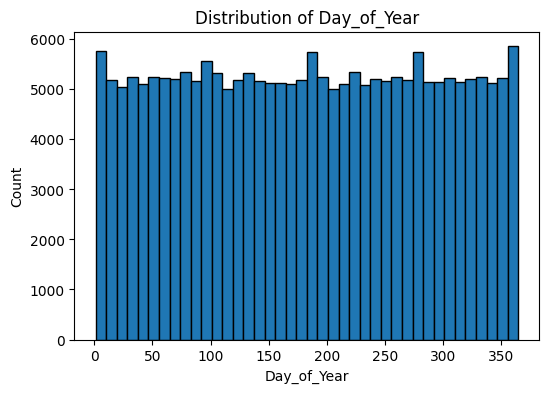

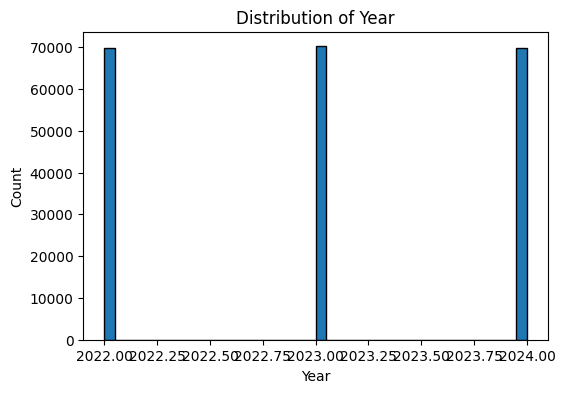

In [8]:
# DATA EXPLORATION: Distributions for Numeric Features

# First lets go ahead and take a look at the distributions of all our numeric features, see if there's anything interesting (skewness, outliers, negatives, etc.)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Looks like we have 7 categorical features that are non-numeric: Breed, Climate_Zone, Management_System, Lactation_Stage, Feed_Type, Date, Farm_ID
print("Numeric columns:", numeric_cols.__len__())

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    df[col].plot(kind='hist', bins=40, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


# Milk Yield seems to be normally or slightly right-skewed distributed, not too many outliers

0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Milk_Yield_L, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Days_in_Milk, dtype: float64


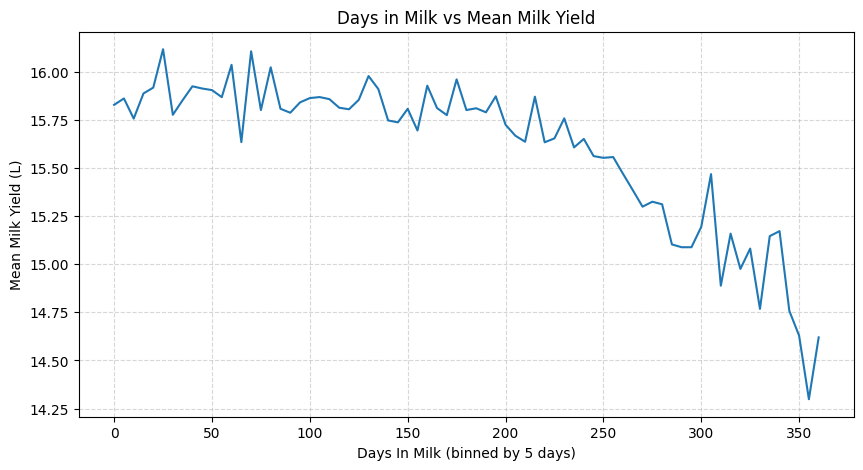

In [9]:
# RANDOM DATA EXPLORATION

# Testing the previous week zero yield entries here
zero_prev = df[df['Previous_Week_Avg_Yield'] == 0]
print(len(zero_prev))
print(zero_prev['Milk_Yield_L'].describe())
print(zero_prev['Days_in_Milk'].describe())



# We are taking a look at Days in Milk to see where the biggest falloff in milk yield happens
# Bin Days_in_Milk into groups (every 5 days)
df['DIM_bin'] = (df['Days_in_Milk'] // 5) * 5

curve = df.groupby('DIM_bin')['Milk_Yield_L'].mean()
plt.figure(figsize=(10,5))
plt.plot(curve.index, curve.values)
plt.xlabel("Days In Milk (binned by 5 days)")
plt.ylabel("Mean Milk Yield (L)")
plt.title("Days in Milk vs Mean Milk Yield")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
# Looks like it happens around 250 days, starting to drop off at 200 days

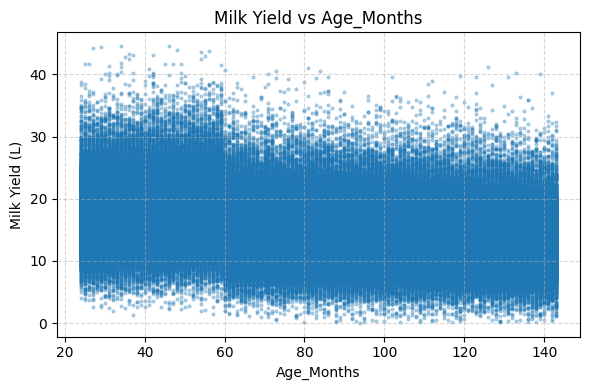

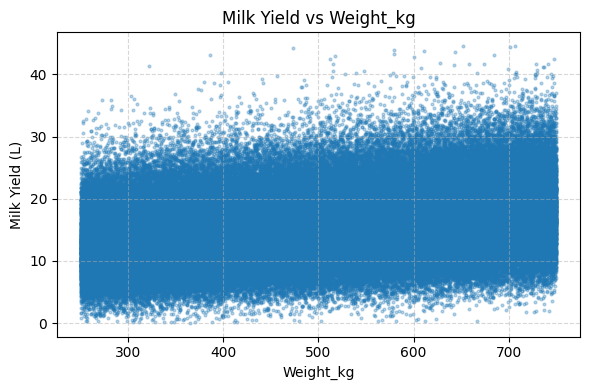

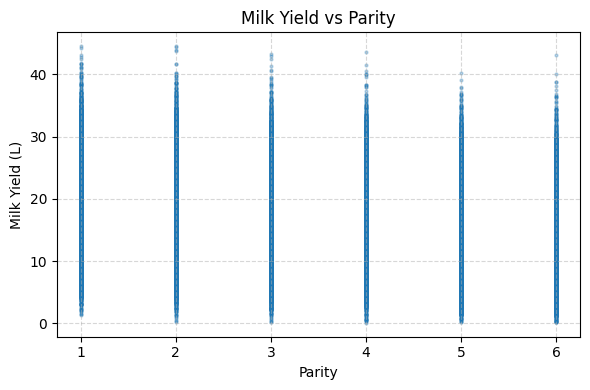

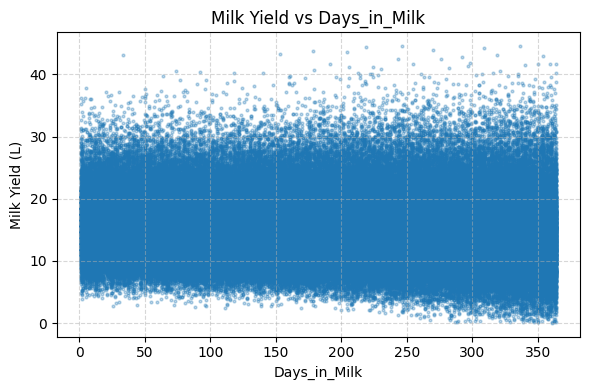

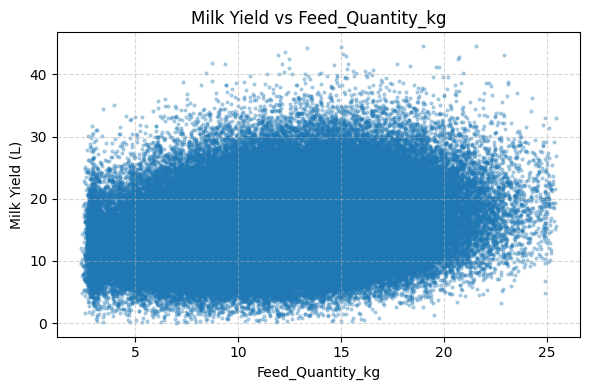

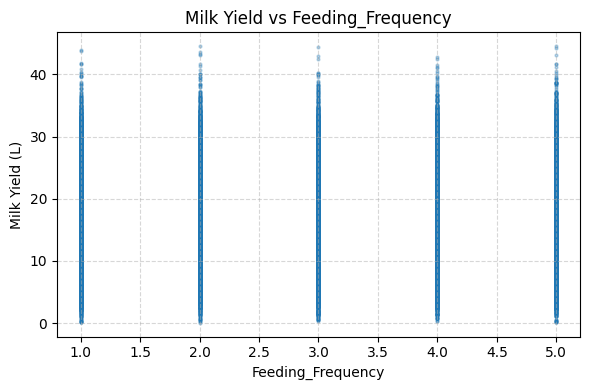

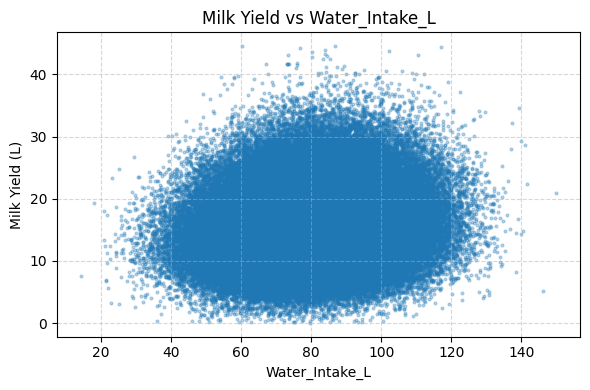

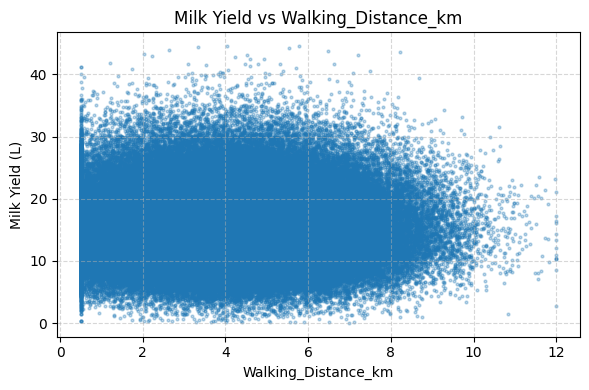

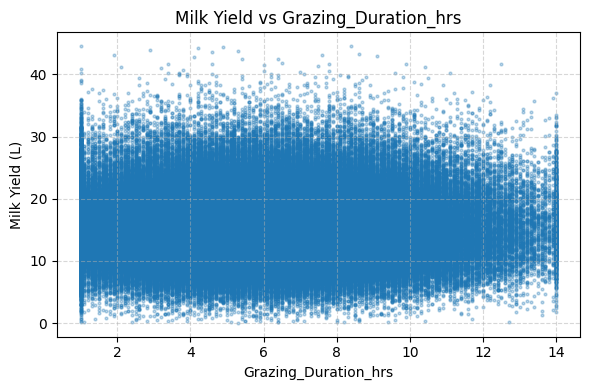

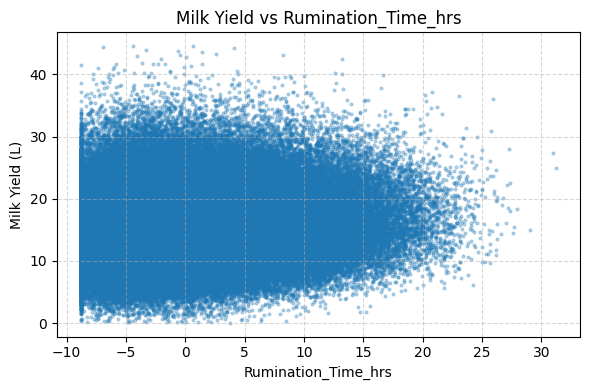

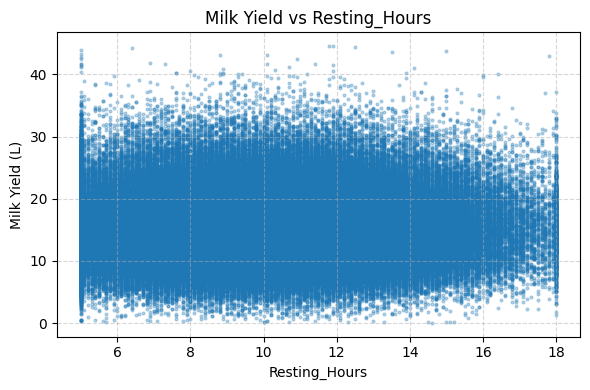

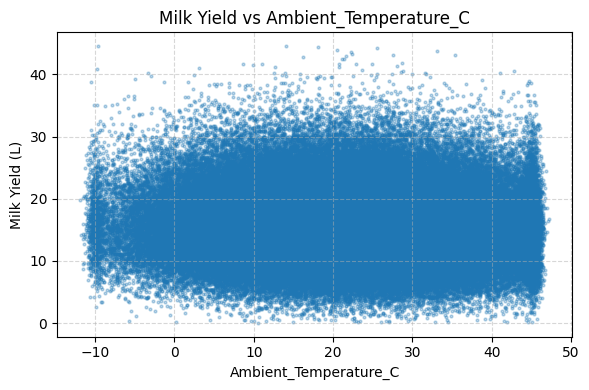

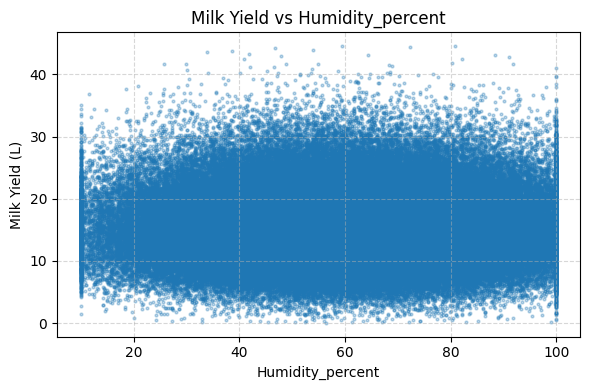

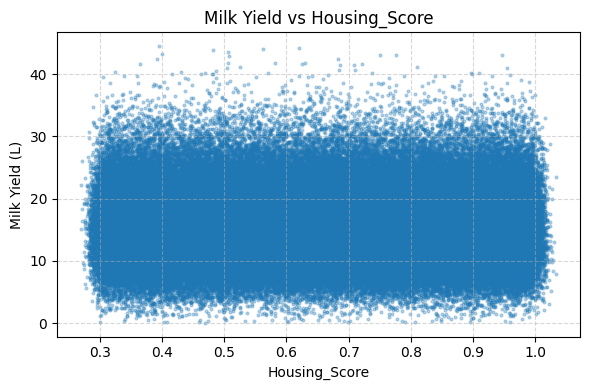

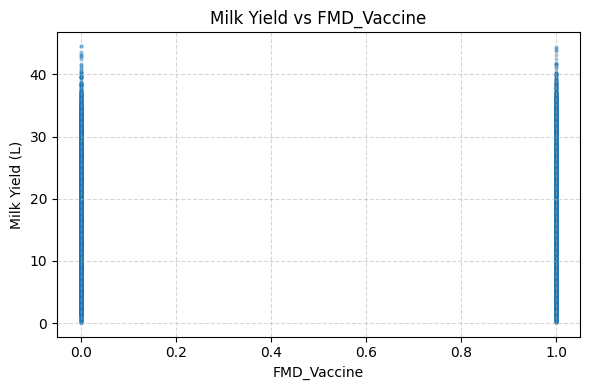

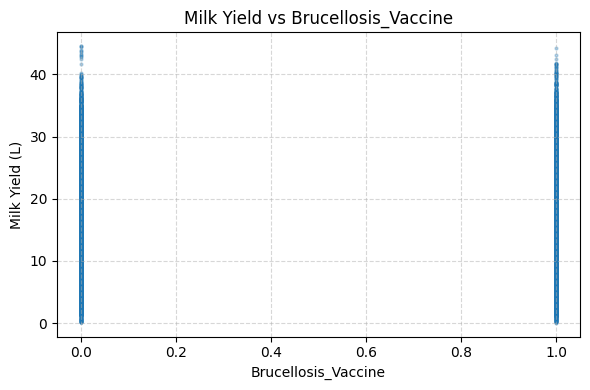

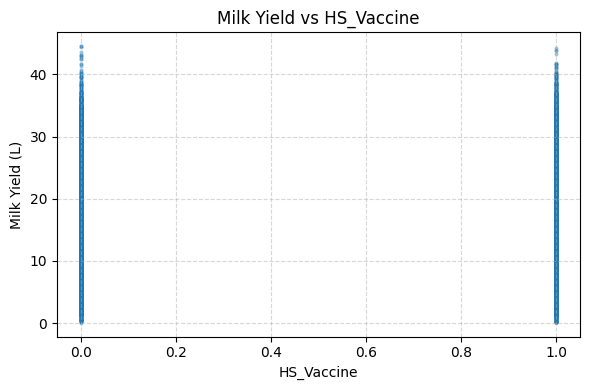

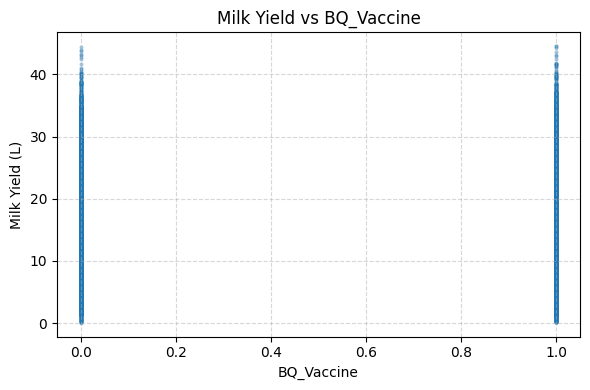

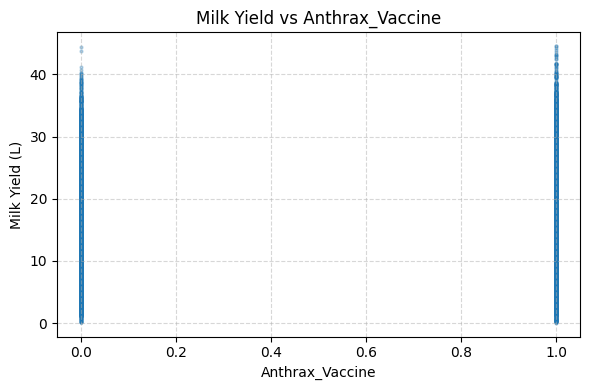

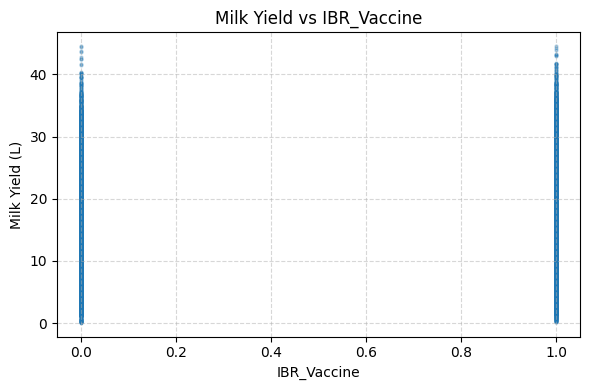

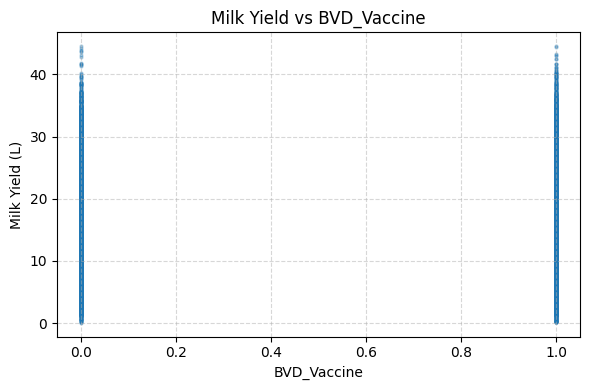

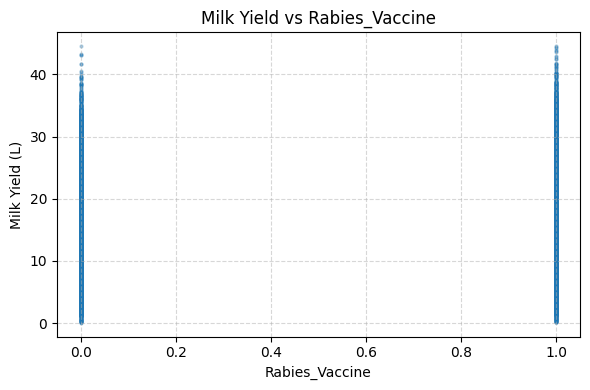

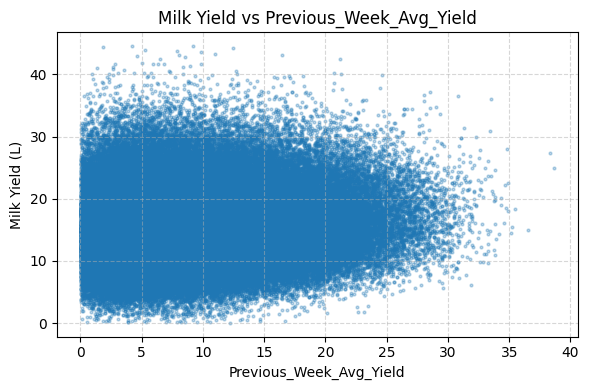

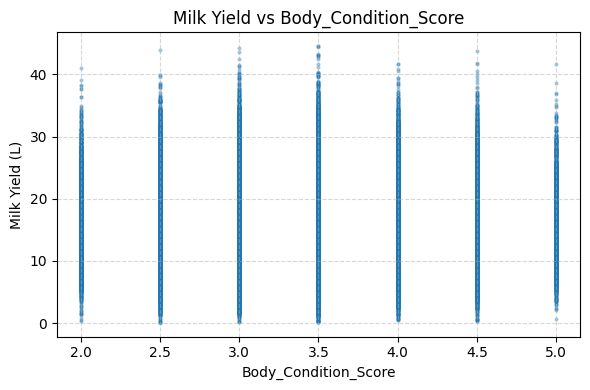

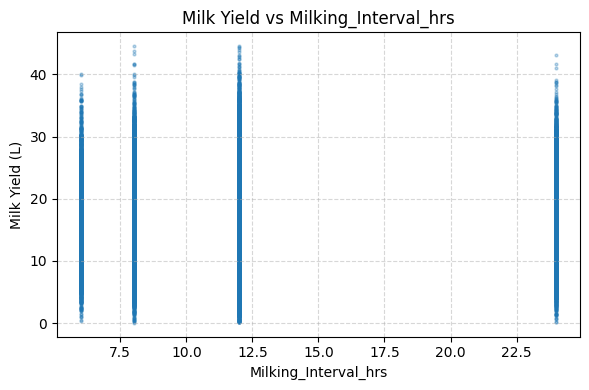

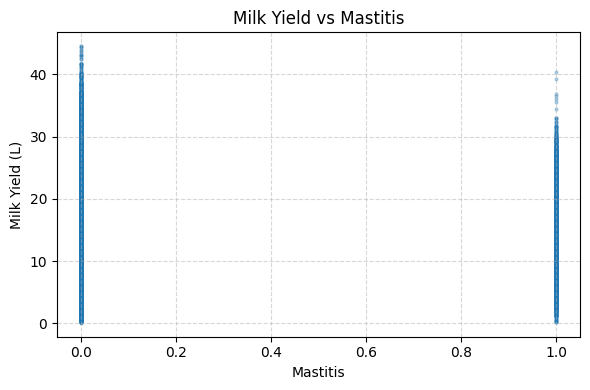

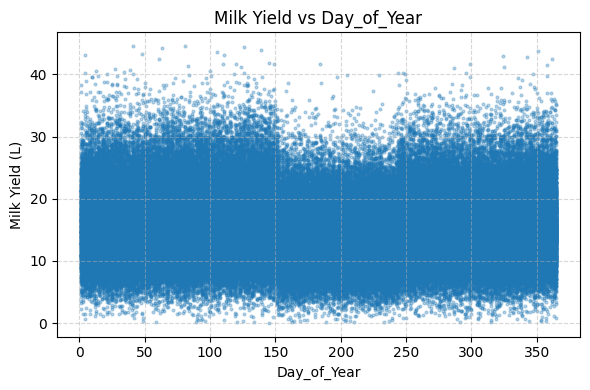

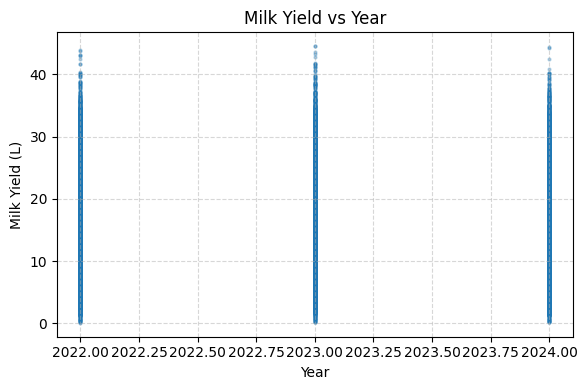

In [10]:
# DATA EXPLORATION: Scatterplots of Numeric Features vs Milk Yield

# Honestly nothing to take away from here which makes sense since we saw very low correlations earlier, at most 0.3
for col in numeric_cols:
    if (col != 'Milk_Yield_L'):
        plt.figure(figsize=(6,4))
        plt.scatter(df[col], df['Milk_Yield_L'], s=4, alpha=0.3)
        plt.title(f"Milk Yield vs {col}")
        plt.xlabel(col)
        plt.ylabel("Milk Yield (L)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

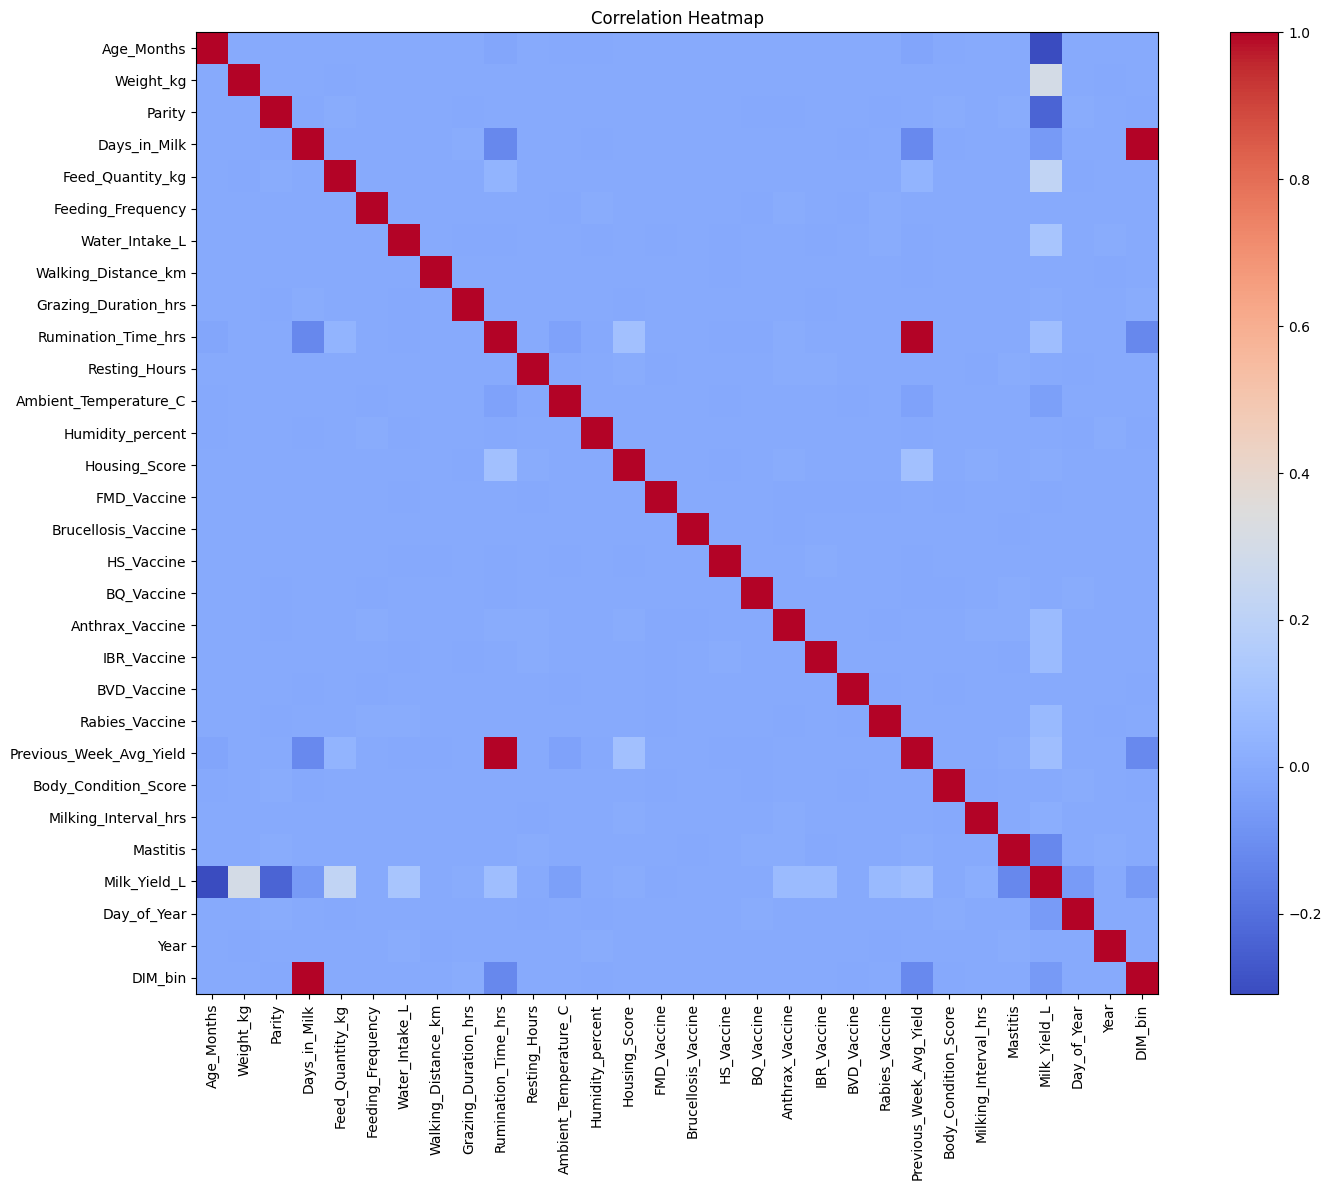

In [11]:
# DATA EXPLORATION: Correlation Heatmap Between Numeric Features
corr = df.corr(numeric_only=True)

plt.figure(figsize=(16,12))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.tight_layout()
plt.show()


Categorical columns: ['Breed', 'Climate_Zone', 'Management_System', 'Lactation_Stage', 'Feed_Type', 'Farm_ID']


/tmp/ipykernel_53013/2174006967.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


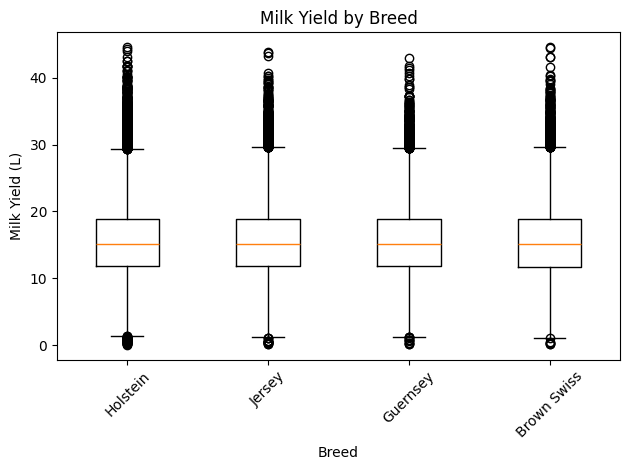

/tmp/ipykernel_53013/2174006967.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


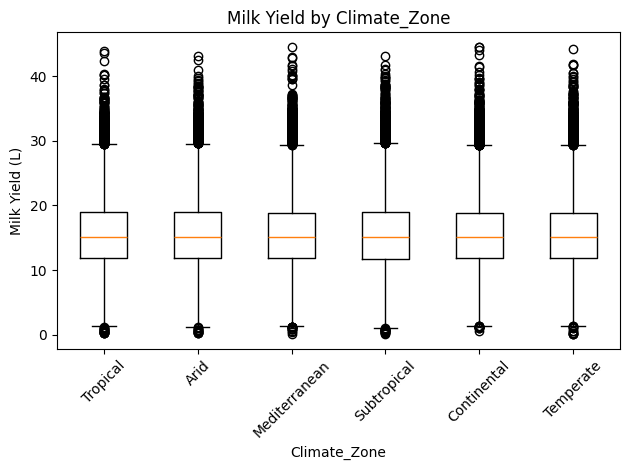

/tmp/ipykernel_53013/2174006967.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


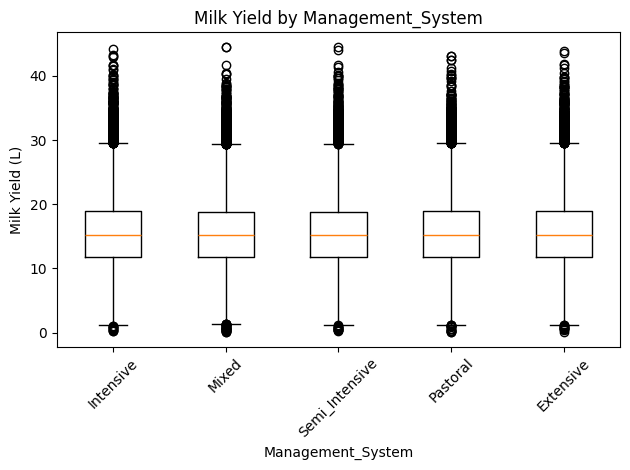

/tmp/ipykernel_53013/2174006967.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


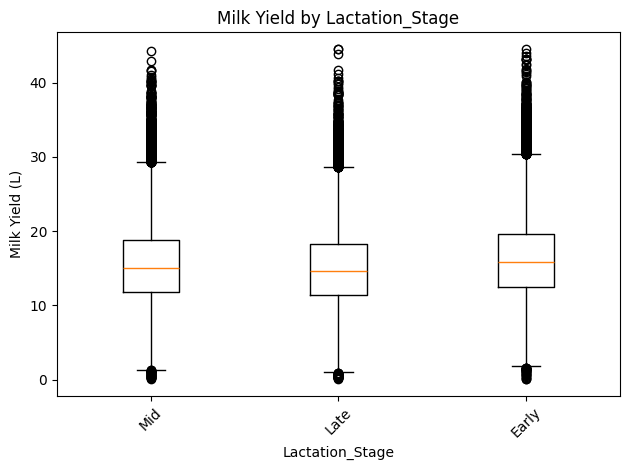

/tmp/ipykernel_53013/2174006967.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


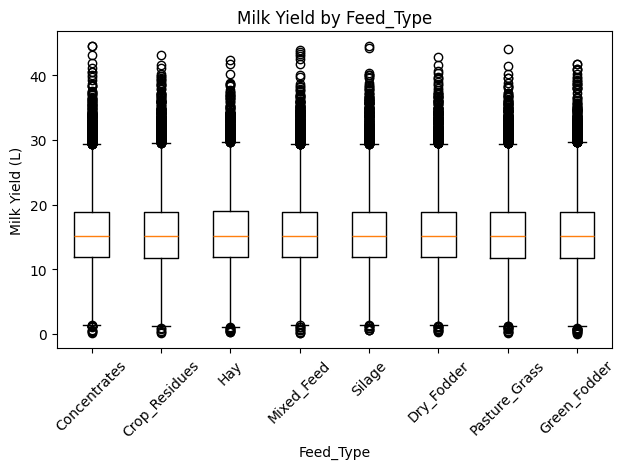

In [13]:
# DATA EXPLORATION: Boxplots of Categorical Features vs Milk Yield

categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols.tolist())

# Lets go ahead and drop Date and Farm_ID for now since they have too many unique categories to visualize effectively
# Note: Date was already dropped in data cleaning, so we only drop columns that exist
cols_to_drop = [col for col in ['Date', 'Farm_ID'] if col in categorical_cols]
categorical_cols = categorical_cols.drop(cols_to_drop)

for col in categorical_cols:
    categories = df[col].dropna().unique()

    data = [df.loc[df[col] == category, 'Milk_Yield_L'].values for category in categories]

    plt.boxplot(data, labels=categories)
    plt.title(f"Milk Yield by {col}")
    plt.ylabel("Milk Yield (L)")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Visually all of these categorical features look almost identically distibuted for Milk_Yield_L

# Feature Engineering

In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# DATA PREPROCESSING PIPELINE (convert into a pipeline to pass into models differently later)
# We should have different pipelines for NaN imputation, low variance filter, correlation filter, scaling. one hot encoding, ordinal encoding, etc.


# Custom Target Encoder for Farm_ID
# This encoder computes the mean target value per category with smoothing to prevent overfitting
class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target encoder that encodes categorical values based on the mean target value.
    Uses additive smoothing (James-Stein estimator) to handle rare categories.
    """
    def __init__(self, smoothing=10.0):
        self.smoothing = smoothing
        self.encoding_map_ = None
        self.global_mean_ = None
    
    def fit(self, X, y=None):
        """
        Fit the encoder. X should be a 2D array with a single column (Farm_ID).
        y should be the target variable (Milk_Yield_L).
        """
        if y is None:
            raise ValueError("TargetEncoder requires y to be provided during fit")
        
        X = np.array(X).ravel()  # Flatten to 1D
        y = np.array(y).ravel()
        
        # Compute global mean
        self.global_mean_ = np.mean(y)
        
        # Compute mean target per category
        encoding_map = {}
        unique_cats = np.unique(X)
        
        for cat in unique_cats:
            mask = (X == cat)
            if np.sum(mask) > 0:
                cat_mean = np.mean(y[mask])
                cat_count = np.sum(mask)
                # Apply smoothing: weighted average between category mean and global mean
                smoothed_mean = (cat_mean * cat_count + self.global_mean_ * self.smoothing) / (cat_count + self.smoothing)
                encoding_map[cat] = smoothed_mean
        
        self.encoding_map_ = encoding_map
        return self
    
    def transform(self, X):
        """
        Transform categorical values to their encoded target means.
        Unknown categories are mapped to the global mean.
        """
        if self.encoding_map_ is None:
            raise ValueError("TargetEncoder must be fitted before transform")
        
        X = np.array(X).ravel()
        result = np.zeros(len(X))
        
        for i, val in enumerate(X):
            if val in self.encoding_map_:
                result[i] = self.encoding_map_[val]
            else:
                # Unknown category: use global mean
                result[i] = self.global_mean_
        
        return result.reshape(-1, 1)  # Return as 2D array for compatibility
    
    def fit_transform(self, X, y=None):
        """Fit and transform in one step."""
        return self.fit(X, y).transform(X)


# THE PLAN:
# Rumination seems to have some weird values, half of them are negative and they go up to over 24 hours a day? We will leave it as is since so much of the data seems to be like that
# 


# NEW BINARY FLAGS
df['Prev_Week_Missing'] = (df['Previous_Week_Avg_Yield'].isna()).astype(int)
df['Is_Late_Lactation'] = (df['Days_in_Milk'] > 250).astype(int) # past 250 seems to be when yield drops off most

# Now we split our data into features and labels
features = df.drop(columns=['Milk_Yield_L'])
labels = df['Milk_Yield_L']


numeric_features = features.select_dtypes(include=[np.number]).columns.tolist()
one_hot_features = ['Breed', 'Climate_Zone', 'Management_System', 'Feed_Type'] # We are using one hot for now, hopefully this isnt too many dimensions, but may use frequency encoding later
ordinal_features = ['Lactation_Stage']
farm_id_features = ['Farm_ID']  # Target encoding for Farm_ID
lactation_order = ['Early', 'Mid', 'Late']


# PIPELINES
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
unscaled_numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[lactation_order]))
])
# Target encoding pipeline for Farm_ID
# Note: TargetEncoder requires y during fit, so we'll handle it separately in cross-validation
farm_id_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder(smoothing=10.0))
])


# Custom preprocessor wrapper that handles target encoding with y
class PreprocessorWithTargetEncoding(BaseEstimator, TransformerMixin):
    """
    Wrapper for ColumnTransformer that handles target encoding separately.
    This allows us to pass y to the TargetEncoder while keeping other transformers standard.
    """
    def __init__(self, base_transformer, target_encoder_col, target_encoder_pipeline):
        self.base_transformer = base_transformer
        self.target_encoder_col = target_encoder_col
        self.target_encoder_pipeline = target_encoder_pipeline
        self.target_encoder_fitted_ = False
    
    def fit(self, X, y=None):
        """Fit the preprocessor. X should be a DataFrame, y should be the target."""
        if y is None:
            raise ValueError("PreprocessorWithTargetEncoding requires y to be provided during fit")
        
        X = X.copy()
        y = np.array(y).ravel()
        
        # Extract the column for target encoding
        target_col = X[self.target_encoder_col].values.reshape(-1, 1)
        
        # Fit the target encoder with y
        self.target_encoder_pipeline.fit(target_col, y)
        self.target_encoder_fitted_ = True
        
        # Remove the target-encoded column from X before passing to base transformer
        X_without_target = X.drop(columns=[self.target_encoder_col])
        
        # Fit the base transformer (without the target-encoded column)
        self.base_transformer.fit(X_without_target)
        
        return self
    
    def transform(self, X):
        """Transform the data."""
        if not self.target_encoder_fitted_:
            raise ValueError("PreprocessorWithTargetEncoding must be fitted before transform")
        
        X = X.copy()
        
        # Transform the target-encoded column
        target_col = X[self.target_encoder_col].values.reshape(-1, 1)
        target_encoded = self.target_encoder_pipeline.transform(target_col)
        
        # Remove the original column and transform the rest
        X_without_target = X.drop(columns=[self.target_encoder_col])
        base_transformed = self.base_transformer.transform(X_without_target)
        
        # Combine the results
        if hasattr(base_transformed, 'toarray'):  # Handle sparse matrices
            base_transformed = base_transformed.toarray()
        
        # Concatenate base transformed features with target-encoded feature
        result = np.hstack([base_transformed, target_encoded])
        
        return result


# Create base transformers without Farm_ID
scaled_base_transformer = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('onehot', onehot_pipeline, one_hot_features),
    ('ordinal', ordinal_pipeline, ordinal_features)
])

unscaled_base_transformer = ColumnTransformer(transformers=[
    ('num', unscaled_numeric_pipeline, numeric_features),
    ('onehot', onehot_pipeline, one_hot_features),
    ('ordinal', ordinal_pipeline, ordinal_features)
])

# Create preprocessors with target encoding
scaled_preprocessor = PreprocessorWithTargetEncoding(
    base_transformer=scaled_base_transformer,
    target_encoder_col='Farm_ID',
    target_encoder_pipeline=farm_id_pipeline
)

# This is the one we will use for models like decision forests that don't need scaling
unscaled_preprocessor = PreprocessorWithTargetEncoding(
    base_transformer=unscaled_base_transformer,
    target_encoder_col='Farm_ID',
    target_encoder_pipeline=farm_id_pipeline
)

# NOTE: When using these preprocessors in cross-validation or train/test splits:
# - Always call fit() with both X and y: preprocessor.fit(X_train, y_train)
# - The target encoder will automatically use only training data to compute encodings,
#   preventing target leakage into validation/test sets
# - For prediction on test data, use: preprocessor.transform(X_test) (no y needed)












# Using ordinal encoding for Lactation_Stage because it has a natural order
# order = ['Early', 'Mid', 'Late']
# df['Lactation_Stage'] = pd.Categorical(df['Lactation_Stage'], categories=order, ordered=True).codes + 1


















# df.head()

# DATA EXPLORATION NOTES
# Data may need to be scaled in our CV-loop later based on the model we choose to use
# Feed_Quantity_kg has some NaN entries that need to be replaced
# more relevant features: breed, age, weight, lactation stage, Previous_Week_Avg_Yield,Body_Condition_Score, Mastitis


# TODO:
# imputation using mean/median (or ffill if we're lazy) for food quantity NaNs (about 16k of them)
# We have a LOT of low variance features, maybe filter them out if they seem irrelevant


In [ ]:
# Model Training and Evaluation

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(features.columns)}")
print()


In [ ]:
# Preprocess the data
print("Preprocessing training data...")
scaled_preprocessor.fit(X_train, y_train)
X_train_processed = scaled_preprocessor.transform(X_train)
X_test_processed = scaled_preprocessor.transform(X_test)

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")
print()


In [ ]:
# Train and evaluate multiple models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = []

print("Training models...")
print("=" * 80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    training_time = time.time() - start_time
    
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Training Time (s)': training_time
    })
    
    print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Training time: {training_time:.2f}s")

print("\n" + "=" * 80)
print("\nSummary of Results:")
print("=" * 80)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


In [ ]:
# Train tree-based models with unscaled preprocessor (tree models don't need scaling)
print("\n" + "=" * 80)
print("Training tree-based models with unscaled preprocessor...")
print("=" * 80)

# Preprocess with unscaled preprocessor
unscaled_preprocessor.fit(X_train, y_train)
X_train_unscaled = unscaled_preprocessor.transform(X_train)
X_test_unscaled = unscaled_preprocessor.transform(X_test)

tree_models = {
    'Random Forest (Unscaled)': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting (Unscaled)': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

tree_results = []

for name, model in tree_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_unscaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_unscaled)
    y_test_pred = model.predict(X_test_unscaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    training_time = time.time() - start_time
    
    tree_results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Training Time (s)': training_time
    })
    
    print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Training time: {training_time:.2f}s")

# Combine all results
all_results = results + tree_results
all_results_df = pd.DataFrame(all_results)

print("\n" + "=" * 80)
print("\nAll Results Summary:")
print("=" * 80)
print(all_results_df.to_string(index=False))


In [ ]:
# Cross-validation for more robust evaluation
print("\n" + "=" * 80)
print("Cross-Validation Evaluation (5-fold)...")
print("=" * 80)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

# Best models from previous evaluation
best_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

for name, model in best_models.items():
    print(f"\nEvaluating {name} with cross-validation...")
    
    # Use unscaled preprocessor for tree models
    cv_scores_rmse = []
    cv_scores_mae = []
    cv_scores_r2 = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Preprocess
        unscaled_preprocessor.fit(X_train_fold, y_train_fold)
        X_train_fold_proc = unscaled_preprocessor.transform(X_train_fold)
        X_val_fold_proc = unscaled_preprocessor.transform(X_val_fold)
        
        # Train and predict
        model.fit(X_train_fold_proc, y_train_fold)
        y_pred_fold = model.predict(X_val_fold_proc)
        
        # Calculate metrics
        cv_scores_rmse.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_fold)))
        cv_scores_mae.append(mean_absolute_error(y_val_fold, y_pred_fold))
        cv_scores_r2.append(r2_score(y_val_fold, y_pred_fold))
    
    cv_results.append({
        'Model': name,
        'CV RMSE (mean)': np.mean(cv_scores_rmse),
        'CV RMSE (std)': np.std(cv_scores_rmse),
        'CV MAE (mean)': np.mean(cv_scores_mae),
        'CV MAE (std)': np.std(cv_scores_mae),
        'CV R² (mean)': np.mean(cv_scores_r2),
        'CV R² (std)': np.std(cv_scores_r2)
    })
    
    print(f"  CV RMSE: {np.mean(cv_scores_rmse):.4f} (+/- {np.std(cv_scores_rmse):.4f})")
    print(f"  CV MAE: {np.mean(cv_scores_mae):.4f} (+/- {np.std(cv_scores_mae):.4f})")
    print(f"  CV R²: {np.mean(cv_scores_r2):.4f} (+/- {np.std(cv_scores_r2):.4f})")

cv_results_df = pd.DataFrame(cv_results)
print("\n" + "=" * 80)
print("Cross-Validation Results:")
print("=" * 80)
print(cv_results_df.to_string(index=False))


In [ ]:
# Find the best model based on test R² score
best_model_idx = all_results_df['Test R²'].idxmax()
best_model = all_results_df.loc[best_model_idx]

print("\n" + "=" * 80)
print("BEST MODEL:")
print("=" * 80)
print(f"Model: {best_model['Model']}")
print(f"Test RMSE: {best_model['Test RMSE']:.4f}")
print(f"Test MAE: {best_model['Test MAE']:.4f}")
print(f"Test R²: {best_model['Test R²']:.4f}")
print(f"Training Time: {best_model['Training Time (s)']:.2f}s")
print("=" * 80)

# Note: For regression problems, we use R² (coefficient of determination) as the primary metric
# R² ranges from -∞ to 1, where 1 is perfect prediction
# RMSE and MAE are in the same units as the target (liters of milk)
